## Introduction to Modeling with Python

Now that we have seen some examples of modeling and using Python for modeling, we wanted to give you a chance to try your hand!

To that goal, we choose a well structured problem with plenty of resources online to help you along the way. That problem is predicting housing prices and is hosted on Kaggle:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

First, make sure you are signed up on Kaggle and then download the data:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

The data includes both testing and training sets as well as a sample submission file. 

Your goal is the predict the sales price for each house where root mean squared error is the evaluation metric. To get some ideas on where to start, feel free to check out Kaggle Kernels:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

And the discussion board:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion

Again - the goal of this homework is to get you exposed to modeling with Python. Feel free to use online resources to help guide you, but we expect original thought as well. Our hope is by the end of this homework you will feel comfortable exploring data in Python and building models to make predictions. Also please submit your test results to Kaggle and let us know your ranking and score!


### Grading

This homework is due **Feb. 20, 2018 by 3:00pm Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are they assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns #plt.style.use("seaborn")
%matplotlib inline

### Data Cleaning

In [2]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
all_data = pd.concat((test, train), ignore_index=True)

In [3]:
all_data.shape

(2919, 81)

In [4]:
train.shape

(1460, 81)

In [5]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,896,0,0,NaN,2,1Fam,TA,No,468.0,144.0,...,WD,120,Pave,5,882.0,AllPub,140,1961,1961,2010
1,1329,0,0,NaN,3,1Fam,TA,No,923.0,0.0,...,WD,0,Pave,6,1329.0,AllPub,393,1958,1958,2010
2,928,701,0,NaN,3,1Fam,TA,No,791.0,0.0,...,WD,0,Pave,6,928.0,AllPub,212,1997,1998,2010
3,926,678,0,NaN,3,1Fam,TA,No,602.0,0.0,...,WD,0,Pave,7,926.0,AllPub,360,1998,1998,2010
4,1280,0,0,NaN,2,TwnhsE,TA,No,263.0,0.0,...,WD,144,Pave,5,1280.0,AllPub,0,1992,1992,2010


**Drop Variables**

After looping through the dataframe and printing out the normalized value counts of each column, I was able to identify which columns were worth keeping based on categorical distribution skewness. The columns with a category containing more than 60% of the data will be dropped.

In [6]:
# dropped array stores skewed categorical columns to be dropped
dropped = []
keep = []
for i in train:
    if train[i].value_counts(normalize=True, dropna=False).iloc[0] > .6:
            ###print(train[i].value_counts(normalize=True, dropna=False))
            dropped.append(i)
    else:
            keep.append(i)

In [7]:
len(dropped)

40

In [8]:
print("Columns to drop: ")
for i in dropped:
    print(i, sep='', end=', ', flush=True)

Columns to drop: 
MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Condition1, Condition2, BldgType, RoofStyle, RoofMatl, ExterQual, ExterCond, BsmtCond, BsmtExposure, BsmtFinType2, BsmtFinSF2, Heating, CentralAir, Electrical, LowQualFinSF, BsmtHalfBath, HalfBath, KitchenAbvGr, Functional, GarageQual, GarageCond, PavedDrive, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, SaleType, SaleCondition, 

In [9]:
# drops variables that do not meet the 60% threshhold
train.drop(dropped, axis=1, inplace=True)

**Additional Columns to Drop**

The following columns were dropped for reasons other than not meeting the categorical skewness threshold:
- 'Exterior2nd': The variable Exterior1st provides a sufficient metric for type of home exterior material
- 'GarageType': Since this variable has a lot of categories and there are many other descriptive "garage" variables, it does not make sense to keep
- 'MSSubClass': Based on the normalized categorical distribution of this variable, it is nearly colinear with 'HouseStyle' + 'YearBuilt' and therefore provides no additional predictive power.
- 'Neighborhood' is unlikely to be useful, since houses within the same neighborhood generally have similar qualities.
- 'Id' is an arbitrary identifier and has no predictive power

In [10]:
# Drops other variables that do not add predictive power
train.drop(["Exterior2nd", "GarageType", "MSSubClass", "Neighborhood", "Id"], axis=1, inplace=True)

**Columns to transform:**
- 'Exterior1st' get dummies for top 4 categories since they make up over 80% of the data
- 'HouseStyle' get dummies for 1 story and 2 story houses
- 'GarageFinish' encode as 1 for finished and 0 for unfinished
- 'Foundation' get dummies for 'PConc' and 'CBlock' and consolidate the other variables to 'other' category since they make up +87% of the data.
- 'MasVnrType' get dummies after consolidating 'brick' categories
- 'BsmtQual', 'HeatingQC', 'KitchenQual', and 'Fireplace' change to numeric scale
- 'BsmtFinType1' encode as a numeric quality scale

In [11]:
### delete from final draft
print("Columns to keep: ")
for i in keep:
    print(i, sep='', end=', ', flush=True)

Columns to keep: 
Id, MSSubClass, LotFrontage, LotArea, Neighborhood, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, Foundation, BsmtQual, BsmtFinType1, BsmtFinSF1, BsmtUnfSF, TotalBsmtSF, HeatingQC, 1stFlrSF, 2ndFlrSF, GrLivArea, BsmtFullBath, FullBath, BedroomAbvGr, KitchenQual, TotRmsAbvGrd, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, MoSold, YrSold, SalePrice, 

In [12]:
### train.LotArea.value_counts(normalize=True, dropna=False)

In [13]:
# Reduces 'Exterior1st' column to just have 5 categories: 'VinylSd', 'HdBoard', 'MetalSd', 'Wd Sdng', and 'Other'
train.Exterior1st = train.Exterior1st.apply(lambda x: x if str(x)[0]=="V" or str(x)[0]=="H" or str(x)[0]=="M" 
                                           or str(x)[0:5]=="Wd Sd" else "Other")
# Creates dummies for new Exterior1st column
train = pd.get_dummies(train, columns=["Exterior1st"])

In [14]:
# Since 80% of the values are either 1 or 2 story houses, the other values are extraneous and uninformative
# Hence, 'HouseStyle_1' essentially serves as an indicator for 1 story or more than 1 story (1.5, 2, 2.5, & split lvl)
train["HouseStyle_1LvL"] = np.where(train.HouseStyle.str.contains("1Story"), 1, 0)
train.drop("HouseStyle", axis=1, inplace=True)

In [15]:
# Encodes 'GarageFinish' column to an indicator for houses with finished garages instead of categories
train.GarageFinish = train.GarageFinish.apply(lambda x: 1 if str(x)[0:3] == "Fin" else 0)

In [16]:
# Consolidates 'BrkFace' and 'BrkCmn' into one 'Brick' category
train.MasVnrType = train.MasVnrType.apply(lambda x: x if str(x)[0:3] != "Brk" else "Brick")

# Creates dummy variables for 'MasVnrType'
train = pd.get_dummies(train, columns=["MasVnrType"])

In [17]:
# Reduces 'Foundation' column to just have 3 categories: 'PConc', 'CBrick', and 'Other'
train.Foundation = train.Foundation.apply(lambda x: x if str(x)[0] == "P" or str(x)[0] == "C" else "Other")

# Creates dummy variables for each Neighborhood
train = pd.get_dummies(train, columns=["Foundation"])

In [18]:
# Dictionary assigning numeric values to categorical columns with a "poor" to "excellent"
num_assignments = {"BsmtQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0},
                  "HeatingQC": {"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0},
                  "KitchenQual": {"Ex":4, "Gd":3, "TA":2, "Fa":1, "Po":0},
                  "FireplaceQu": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, np.nan:0},
                  "BsmtFinType1": {"GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, np.nan:0}}
# Note: For 'BsmtQual', FireplaceQu', and 'BsmtFinType1' the null values are set to zero as their own category. 
        # This makes sense in context because the categories are measuring feature quality; Hence, if a feature is not
        # reported it cannot be characterized.
# Uses the 'num_assignments' dictionary to assign numeric values to the specified columns
train.replace(num_assignments, inplace=True)

In [19]:
# creates variable measuring total square feet of the house
train["TotalSqFt"] = train.TotalBsmtSF + train.GrLivArea
# TotalBsmtSF = Total square feet of basement area
# GrLivArea = Total above grade (ground) living area square feet

train.drop(["TotalBsmtSF", "GrLivArea"], axis=1, inplace=True)

**Imputing Null Values**

In [20]:
Nulls = []
# Prints sum of null values for columns containing nulls
for i in train:
    if train[i].isnull().sum()!=0:
        print(i, train[i].isnull().sum())
        Nulls.append(i)

LotFrontage 259
MasVnrArea 8
GarageYrBlt 81


In [21]:
# Fills the columns with null values (contained in the array "Nulls") with the column averages
train = train.fillna(train[Nulls].mean()).round()

For verification, we can check if any columns in train have null values. We should expect a value of zero.

In [22]:
# Counts the number of columns with null values
train.isnull().any().sum()

0

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
LotFrontage            1460 non-null float64
LotArea                1460 non-null int64
OverallQual            1460 non-null int64
OverallCond            1460 non-null int64
YearBuilt              1460 non-null int64
YearRemodAdd           1460 non-null int64
MasVnrArea             1460 non-null float64
BsmtQual               1460 non-null int64
BsmtFinType1           1460 non-null int64
BsmtFinSF1             1460 non-null int64
BsmtUnfSF              1460 non-null int64
HeatingQC              1460 non-null int64
1stFlrSF               1460 non-null int64
2ndFlrSF               1460 non-null int64
BsmtFullBath           1460 non-null int64
FullBath               1460 non-null int64
BedroomAbvGr           1460 non-null int64
KitchenQual            1460 non-null int64
TotRmsAbvGrd           1460 non-null int64
Fireplaces             1460 non-null int64
FireplaceQu            1460 n

In [24]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [25]:
target = pd.qcut(train.SalePrice, 20)[1:-4]

In [26]:
len(target)

1455

In [27]:
from scipy import stats
train_NO = train[(np.abs(stats.zscore(train)) < 3).all(axis=1)]

In [28]:
len(train_NO)

1138

### Data Visualization

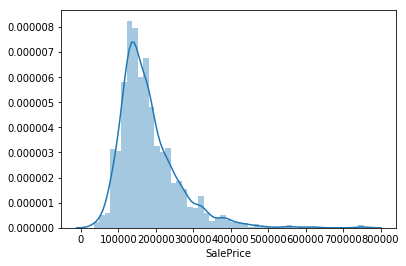

In [29]:
sns.distplot(train.SalePrice) #regularize

### Linear Regression

### Modeling

**1.  Linear Regression**

I begin my modeling with a standard linear regresssion. The data set still has a large number of features, so I do not expect it to be particularly accurate; however, it should serve as an adequate baseline upon which to improve.

In [30]:
train_xs = train_NO.drop(["SalePrice"], axis = 1) # removes the dependent variable from the data set

In [31]:
# Split the data into training and testing sets. 
X_train, X_test, y_train, y_test = train_test_split(train_xs, train_NO.SalePrice, test_size=0.33, random_state=42)

In [32]:
scaler = StandardScaler() # Initializes the StandardScaler function as 'scaler' 
scaler.fit(X_train) # Calculates means and standard deviations of data in order to fit a scaling function
scaled_xtrain = scaler.transform(X_train) # Uses previous calculations to transform data into a scaled dataframe

In [33]:
# Initializes the 'LinearRegression' model from SKLearn.
lin_reg = linear_model.LinearRegression()

In [34]:
# Trains the OLS model with the training subset data.
lin_reg.fit(scaled_xtrain, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [35]:
# Uses OLS model to predict 'SalePrice'
y_predict_OLS = lin_reg.predict(scaler.transform(X_test)) # ??? Need to 'scaler.fit(X_test)' ???

In [36]:
lin_reg.coef_ # Prints the coefficients of the linear regression model

array([  1.53464782e+03,   5.31181974e+03,   1.38605413e+04,
         7.04648193e+03,   7.47110936e+03,   1.47521612e+03,
         2.59927317e+03,   5.21048700e+03,   1.94915128e+03,
         3.30046833e+03,  -3.52546370e+03,   1.36619804e+03,
        -1.04417484e+03,   6.82200058e+03,   7.27238086e+02,
        -5.75926259e+02,  -4.27170555e+03,   4.62359177e+03,
         4.17806785e+03,   3.06318291e+03,   3.87967906e+02,
        -4.46159083e+02,   7.27682188e+02,   4.31118301e+02,
         4.31783625e+03,   1.38890452e+03,   5.13111662e+02,
         1.39991248e+03,  -1.78033826e+03,   1.39902792e+16,
         1.37813217e+16,   1.42315883e+16,   1.71269873e+16,
         1.32019905e+16,   4.03075137e+03,   1.88789578e+03,
         3.35130501e+03,  -6.69261646e+08,  -1.04414295e+16,
        -6.84940543e+15,  -1.02892068e+16,   2.10659545e+04])

In [37]:
np.sqrt(mean_squared_error(y_test, y_predict_OLS))

20005.852543838151

In [38]:
r2_score(y_test, y_predict_OLS)

0.86433530065279573

The mean squared error is extremely large and the R-squared value is suspiciously high, which leads me to believe that the model overfit the data as a result of too many features. I will first trim down the number of features to see if that will improve the accuracy of my linear model.

**2.  Tuning the Linear Model with Lasso**

With such a large number of parameters, it is necessary to determine which are the most informative. Using a Lasso model, also known as L1 regularization, I can identify the most important parameters to use in my models.

In [39]:
lasso_lin_reg = linear_model.Lasso(alpha = 100)
lasso_lin_reg.fit(scaled_xtrain, y_train)

Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [40]:
lasso_lin_reg.score(scaled_xtrain, y_train) # add description/interpretation

0.88249324453707167

In [41]:
# Predicts 'SalePrice' using the x-test data set and lasso coefficients
y_predict_lasso = lasso_lin_reg.predict(scaler.transform(X_test))

In [42]:
np.sqrt(mean_squared_error(y_test, y_predict_lasso))

19881.276561003058

The Lasso model has a root mean squared error of about 36438, which is an improvement from 36523, the RMSE of the original OLS model. However, this is still far from an optimal solution.

In [43]:
np.abs(lasso_lin_reg.coef_)

array([  1.43778929e+03,   5.29734514e+03,   1.39584503e+04,
         6.88344645e+03,   6.68872556e+03,   1.38645245e+03,
         2.22703332e+03,   5.18751268e+03,   1.82776524e+03,
         3.60891221e+03,   3.20480965e+03,   1.32266398e+03,
         0.00000000e+00,   7.08019207e+03,   7.51370905e+02,
         2.05460567e+02,   3.96673208e+03,   4.68568917e+03,
         3.67735426e+03,   2.86634594e+03,   5.96464554e+02,
         0.00000000e+00,   6.15272586e+02,   5.45352001e+02,
         4.13252698e+03,   1.33385067e+03,   4.91233809e+02,
         1.28460122e+03,   1.68622798e+03,   1.48061596e+03,
         1.68933369e+03,   0.00000000e+00,   1.87218153e+03,
         1.66367125e+01,   3.54362007e+03,   0.00000000e+00,
         1.05376189e+03,   0.00000000e+00,   7.55929263e+01,
         0.00000000e+00,   2.35079558e+03,   1.99689134e+04])

In [44]:
# Creates array of top 10 coefficients by absolute value
lasso_lin_reg.coef_[np.abs(lasso_lin_reg.coef_).argsort()[::-1][:10]]

array([ 19968.91340798,  13958.45032869,   7080.1920682 ,   6883.44644612,
         6688.72556469,   5297.34514371,   5187.5126817 ,   4685.68916782,
         4132.52698228,  -3966.73208089])

In [45]:
# Creates array of indices corresponding to the top 10 
np.abs(lasso_lin_reg.coef_).argsort()[::-1][:10]

array([41,  2, 13,  3,  4,  1,  7, 17, 24, 16])

In [46]:
top_10_Lcoefs = train_xs.columns[np.abs(lasso_lin_reg.coef_).argsort()[::-1][:10]]
top_10_Lcoefs

Index(['TotalSqFt', 'OverallQual', '2ndFlrSF', 'OverallCond', 'YearBuilt',
       'LotArea', 'BsmtQual', 'KitchenQual', 'GarageArea', 'BedroomAbvGr'],
      dtype='object')

In [47]:
for col, coef in zip(top_10_Lcoefs, np.abs(lasso_lin_reg.coef_)):
    print(col, coef)

TotalSqFt 1437.78929465
OverallQual 5297.34514371
2ndFlrSF 13958.4503287
OverallCond 6883.44644612
YearBuilt 6688.72556469
LotArea 1386.45245361
BsmtQual 2227.03332446
KitchenQual 5187.5126817
GarageArea 1827.76523948
BedroomAbvGr 3608.91220696


The coefficients of the above features have the largest relative magnitude. I will make a new dataframe and re-run my linear model see if it improves accuracy.

In [48]:
# Creates new dataframes using only the top 10 features extracted with the Lasso regression
df_xtrain2 = pd.DataFrame(data=scaled_xtrain, columns=train_xs.columns)[top_10_Lcoefs]
df_xtest2 = pd.DataFrame(data=scaler.transform(X_test), columns=train_xs.columns)[top_10_Lcoefs]

In [49]:
df_xtrain2.head()

,TotalSqFt,OverallQual,2ndFlrSF,OverallCond,YearBuilt,LotArea,BsmtQual,KitchenQual,GarageArea,BedroomAbvGr
0,0.498579,0.086221,-0.782935,-0.578571,-0.235236,2.542637,-0.727819,-0.716766,2.308140,0.226934
1,1.121320,0.928531,1.447719,-0.578571,0.932067,0.120796,0.825676,-0.716766,0.069741,0.226934
2,0.390487,-2.440710,0.941667,-0.578571,-2.363846,0.300316,-2.281314,-0.716766,-0.112879,0.226934
3,-0.837249,0.086221,-0.782935,0.361453,0.245418,-1.168648,0.825676,-0.716766,-0.008525,-1.167613
4,0.895455,1.770842,-0.782935,-0.578571,0.554410,-0.679940,0.825676,0.948403,0.450634,-2.562161


In [50]:
lin_reg.fit(df_xtrain2, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [51]:
y_predict_OLS2 = lin_reg.predict(df_xtest2)

In [52]:
np.sqrt(mean_squared_error(y_test, y_predict_OLS2))

20307.037328028455

While this linear regression does not improve the mean squared error of the original OLS regression, it achieves a relatively comparable RMSE with less than 25% of the features. This fact may indicate that this new model has a lower likelihood of overfitting. To verify that this model performs better out of sample, I will compare the training and testing RMSEs' of a model using both the original data and the new data frame (the 10 feature df derived from the lasso model). I expect that the model using fewer features will have training and test RMSEs that are closer together.

**3.  GridSearchCV with L1, L2, and Elasticnet Specifications**

The following model uses all of the features.

In [53]:
param_grid = {"penalty": ['l2','l1','elasticnet'], 'alpha':[.01, .1, .5, 1, 10], 
              "eta0": [ .001, .003, .01, .03, .1, .3, 1, 3], "tol": [.001, .0001]}
grid_search = GridSearchCV(linear_model.SGDRegressor(), param_grid, scoring='neg_mean_squared_error')

grid_search.fit(scaled_xtrain, y_train)
print("Best Parameters: {}".format(grid_search.best_params_))

Best Parameters: {'alpha': 0.5, 'eta0': 0.01, 'penalty': 'l1', 'tol': 0.0001}


In [54]:
# Calculates train and test predictions using best estimator found during the grid search
y_predict_xtrain_all = grid_search.best_estimator_.predict(scaled_xtrain)
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train, y_predict_xtrain_all))))

y_predict_xtest_all = grid_search.best_estimator_.predict(scaler.transform(X_test))
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_predict_xtest_all))))

Train RMSE: 19814.138842960525
Test RMSE: 20245.427826413306


The following model uses only the 10 features determined most important by the previous Lasso model.

In [55]:
param_grid = {"penalty": ['l2','l1','elasticnet'], 'alpha':[.01, .1, .5, 1, 10], 
              "eta0": [ .001, .003, .01, .03, .1, .3, 1, 3], "tol": [.001, .0001]}
grid_search = GridSearchCV(linear_model.SGDRegressor(), param_grid, scoring='neg_mean_squared_error')

grid_search.fit(df_xtrain2, y_train) # df_xtrain2, y_train
print("Best Parameters: {}".format(grid_search.best_params_))

Best Parameters: {'alpha': 0.01, 'eta0': 0.03, 'penalty': 'elasticnet', 'tol': 0.0001}


In [56]:
# Calculates train and test predictions using best estimator found during the grid search
y_predict_xtrain_top10 = grid_search.best_estimator_.predict(df_xtrain2) # df_xtrain2
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train, y_predict_xtrain_top10))))

y_predict_xtest_top10 = grid_search.best_estimator_.predict(df_xtest2) # df_xtest2 = RMSE 40,473.7
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_predict_xtest_top10))))

Train RMSE: 21943.079986754765
Test RMSE: 20018.772931476295


As expected, the model using only 10 features performs significantly better out of sample than the model using all of the original features. This confirms my suspicion that the original model with all of the features overfit the training data. However, the RMSE is still quite awful, so I will move on to other models in hopes of improving predictive accuracy.

**4.  K-Nearest Neighbors**

In [57]:
from sklearn.neighbors import KNeighborsRegressor

In [58]:
kn_reg = KNeighborsRegressor()

In [64]:
gridsearchkn  = GridSearchCV(kn_reg, {"n_neighbors": [1, 3, 5, 7, 9, 11, 13], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring = 'neg_mean_squared_error')

In [65]:
gridsearchkn.fit(df_xtrain2, y_train) # df_xtrain2 # scaled_xtrain

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [66]:
print("Best Parameters: {}".format(gridsearchkn.best_params_))

Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


In [67]:
y_predictKN_xtrain = gridsearchkn.best_estimator_.predict(df_xtrain2) # df_xtrain2 # scaled_xtrain
print("Train RMSE: {}".format(np.sqrt(mean_squared_error(y_train,y_predictKN_xtrain))))
y_predictKN_xtest = gridsearchkn.best_estimator_.predict(df_xtest2) # df_xtest2 # scaler.transform(X_test)
print("Test RMSE: {}".format(np.sqrt(mean_squared_error(y_test, y_predictKN_xtest))))

Train RMSE: 322.3247792864865
Test RMSE: 21980.970548890855


The K-Nearest Neighbors Regressor gives the best root mean squared error thus far, but that is not saying much given the still very high RMSE of 36,340.